# 🩺 Medicine Recommendation System using Machine Learning

Student Name:  Akhil S R  
Class:M.Tech (Computer Science and Artificial Intelligence)  
Institution: [Your Institution Name]  
Faculty Mentor: [Mentor Name]  
Submission Date: November 12, 2025  

This notebook implements the complete workflow for the *Medicine Recommendation System*, including:
- Data Loading & Preprocessing  
- Model Building (SVM & Random Forest)  
- Evaluation and Visualization  
- Result Analysis for the final project report

In [30]:
# Imports and settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

sns.set(style="whitegrid")
RSEED = 42
np.random.seed(RSEED)

# Where to save figures
FIGDIR = Path(".") 
FIGDIR.mkdir(exist_ok=True)


In [31]:
# Load datasets
def safe_read(csv_name):
    p = Path(csv_name)
    if p.exists():
        try:
            df = pd.read_csv(p)
            print(f"Loaded {csv_name} — shape: {df.shape}")
            return df
        except Exception as e:
            print(f"Error reading {csv_name}: {e}")
            return None
    else:
        print(f"Missing {csv_name}")
        return None

train_df = safe_read("Training.csv")  # required
severity_df = safe_read("Symptom-severity.csv")
medications_df = safe_read("medications.csv")
precautions_df = safe_read("precautions_df.csv")
description_df = safe_read("description.csv")
workout_df = safe_read("workout_df.csv")


Loaded Training.csv — shape: (4920, 133)
Loaded Symptom-severity.csv — shape: (133, 2)
Loaded medications.csv — shape: (41, 2)
Loaded precautions_df.csv — shape: (41, 6)
Loaded description.csv — shape: (41, 2)
Loaded workout_df.csv — shape: (410, 4)


In [32]:
# Inspect training data and detect symptom columns / target
if train_df is None:
    raise FileNotFoundError("Training.csv is required in the notebook folder. Please add it and re-run.")

print("Training columns:", train_df.columns.tolist())
display(train_df.head())

# Heuristic: training files often have a 'prognosis' or 'disease' target column.
target_candidates = [c for c in train_df.columns if c.lower() in ("prognosis","disease","label","target")]
if target_candidates:
    target_col = target_candidates[0]
else:
    # fallback: assume last column is target
    target_col = train_df.columns[-1]
print("Detected target column:", target_col)

# If dataset encodes symptoms as separate columns (binary), we'll treat X as all columns except target.
# If symptoms are in a single 'symptoms' column (comma-separated), we'll expand to multi-hot.
symptom_text_col = None
# detect if a column contains comma-separated symptoms
for c in train_df.columns:
    if train_df[c].dtype == object and (train_df[c].astype(str).str.contains(",").any()):
        # but avoid target col
        if c != target_col:
            symptom_text_col = c
            break

if symptom_text_col:
    print("Detected symptom text column:", symptom_text_col)
else:
    print("No symptom text column detected; expecting one-hot symptom columns.")


Training columns: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_ urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes', 'breathlessness', 'sweating', 'dehydration', 'indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea', 'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes', 'malaise', 'blurred_and_distorted_vision', 'phlegm', 'throat_irritation', 'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion', 'chest_pain', 'weakness_in_limbs', 'fast_heart_rate'

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


Detected target column: prognosis
No symptom text column detected; expecting one-hot symptom columns.


In [33]:
# Build features X and labels y
if symptom_text_col:
    # Expand comma-separated symptoms to multi-hot features
    def parse_symptoms(s):
        if pd.isna(s): return []
        return [t.strip().lower().replace(" ", "_") for t in str(s).split(",") if t.strip()]
    train_df['symptoms_list'] = train_df[symptom_text_col].apply(parse_symptoms)
    # build vocab
    symptoms_vocab = sorted({sym for lst in train_df['symptoms_list'] for sym in lst})
    print(f"Symptom vocabulary size: {len(symptoms_vocab)}")
    # create multi-hot columns
    X = pd.DataFrame(0, index=train_df.index, columns=symptoms_vocab)
    for i, lst in enumerate(train_df['symptoms_list']):
        for s in lst:
            X.at[i, s] = 1
    y = train_df[target_col].astype(str).str.strip()
else:
    # assume every column except target is a symptom binary column
    X = train_df.drop(columns=[target_col]).copy()
    # normalize column names
    X.columns = [c.strip().lower().replace(" ", "_") for c in X.columns]
    y = train_df[target_col].astype(str).str.strip()
    symptoms_vocab = list(X.columns)

print("X shape:", X.shape, "Unique diseases:", y.nunique())


X shape: (4920, 132) Unique diseases: 41


In [34]:
# Encode labels and split
le = LabelEncoder()
y_enc = le.fit_transform(y)
label_map = {i: cls for i, cls in enumerate(le.classes_)}
print("Detected disease classes:", list(le.classes_)[:10], " ... total:", len(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=RSEED)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Detected disease classes: ['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis']  ... total: 41
Train shape: (3936, 132) Test shape: (984, 132)


In [35]:
# Train models
# SVM (linear kernel) - probability True for possible ROC
svc = SVC(kernel='linear', probability=True, random_state=RSEED)
svc.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RSEED, n_jobs=-1)
rf.fit(X_train, y_train)

# Save models (temp)
joblib.dump(svc, "svc_model.pkl")
joblib.dump(rf, "rf_model.pkl")
print("Models trained and saved: svc_model.pkl, rf_model.pkl")


Models trained and saved: svc_model.pkl, rf_model.pkl


--- SVM (linear) ---
Accuracy: 1.0000, Precision (macro): 1.0000, Recall (macro): 1.0000, F1 (macro): 1.0000
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24

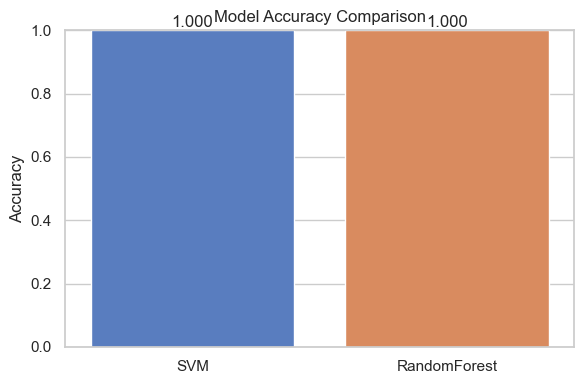

In [36]:
# Evaluate and produce metrics
def evaluate_model(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}, Precision (macro): {prec:.4f}, Recall (macro): {rec:.4f}, F1 (macro): {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    return y_pred, dict(accuracy=acc, precision=prec, recall=rec, f1=f1)

svc_pred, svc_metrics = evaluate_model(svc, X_test, y_test, "SVM (linear)")
rf_pred, rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest")

# accuracy comparison bar
fig, ax = plt.subplots(figsize=(6,4))
names = ['SVM','RandomForest']
vals = [svc_metrics['accuracy'], rf_metrics['accuracy']]
sns.barplot(x=names, y=vals, palette='muted', ax=ax)
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
for i,v in enumerate(vals):
    ax.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.savefig(FIGDIR / "accuracy_comparison.png", dpi=150)
plt.show()


Too many classes for full CM display; plotting heatmap for top classes by frequency.


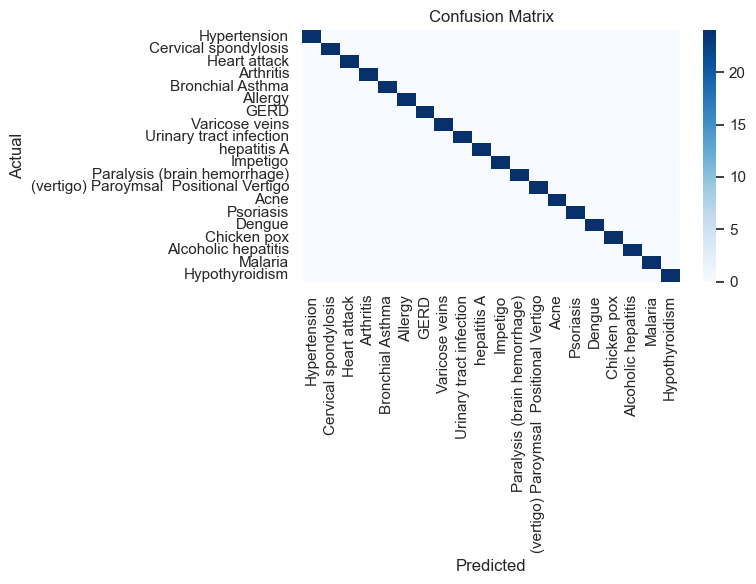

Too many classes for full CM display; plotting heatmap for top classes by frequency.


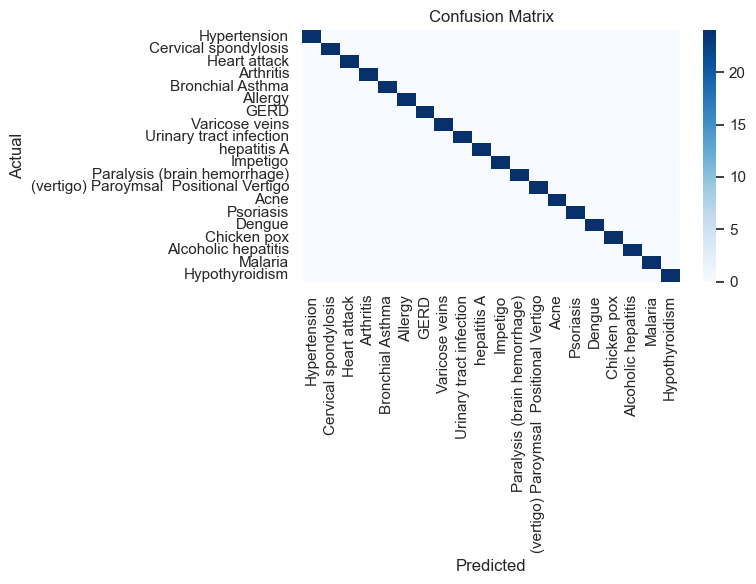

In [37]:
# Confusion matrices (plot top N classes or full if small)
def plot_confusion(y_true, y_pred, classes, fname, max_classes=20):
    cm = confusion_matrix(y_true, y_pred)
    n = len(classes)
    plt.figure(figsize=(8,6))
    if n > max_classes:
        # aggregate by top classes in test set
        print("Too many classes for full CM display; plotting heatmap for top classes by frequency.")
        # pick top classes by frequency
        freq = pd.Series(y_true).value_counts().index[:max_classes]
        idxs = list(freq)
        sub_cm = cm[np.ix_(idxs, idxs)]
        sub_names = [classes[i] for i in idxs]
        sns.heatmap(sub_cm, annot=False, cmap='Blues', xticklabels=sub_names, yticklabels=sub_names)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

# Save confusion matrices
plot_confusion(y_test, svc_pred, le.classes_, FIGDIR / "confusion_svm.png")
plot_confusion(y_test, rf_pred, le.classes_, FIGDIR / "confusion_rf.png")


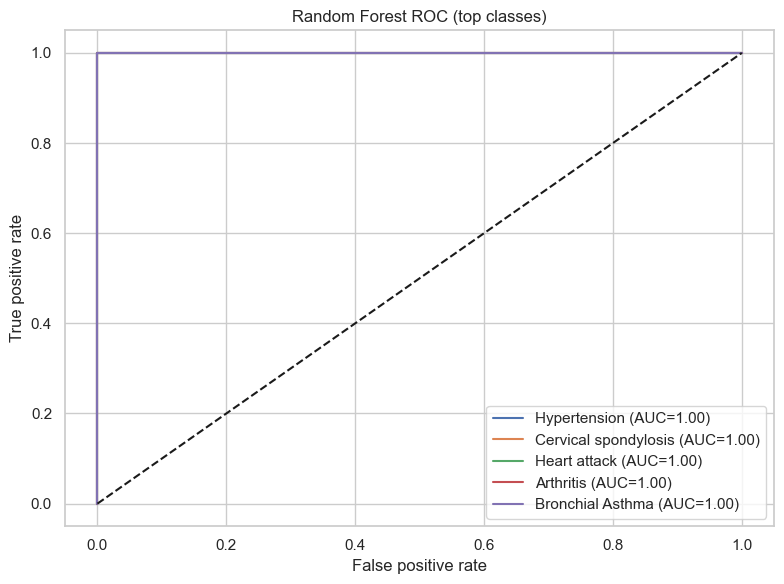

In [38]:
# ROC curves (one-vs-rest) for top few classes
from sklearn.preprocessing import label_binarize
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

# Get predicted probabilities (if available)
probs_svc = svc.predict_proba(X_test)
probs_rf = rf.predict_proba(X_test)

# plot ROC for top 5 classes by support in test set
top_k = 5
top_idx = pd.Series(y_test).value_counts().index[:top_k].tolist()

plt.figure(figsize=(8,6))
for i in top_idx:
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_rf[:, i])
    auc = roc_auc_score(y_test_bin[:, i], probs_rf[:, i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("Random Forest ROC (top classes)")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIGDIR / "roc_curves.png", dpi=150)
plt.show()


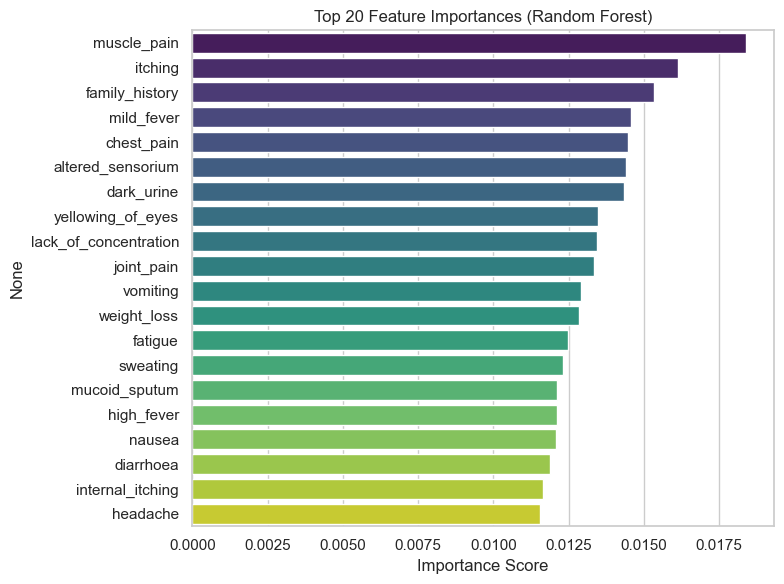

muscle_pain       0.018406
itching           0.016135
family_history    0.015327
mild_fever        0.014565
chest_pain        0.014481
dtype: float64

In [39]:
# Top features influencing prediction
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches='tight')
plt.show()

feature_importance.head()

In [46]:
import joblib

models_dict = {
    "RandomForest": rf,
    "SVM": svc,
    # Add more if needed
}

for name, model in models_dict.items():
    joblib.dump({'model': model, 'label_encoder': le, 'symptoms_vocab': symptoms_vocab}, f"{name}_model.pkl")
    print("Saved model as:", f"{name}_model.pkl")


Saved model as: RandomForest_model.pkl
Saved model as: SVM_model.pkl


In [47]:
# Map symptoms to indices
# Map symptoms to indices
symptom_index = {symptom: idx for idx, symptom in enumerate(X.columns)}
disease_mapping = {i: d for i, d in enumerate(le.classes_)}

def predict_disease(symptoms):
    input_data = [0] * len(symptom_index)
    for symptom in symptoms:
        symptom = symptom.strip().replace(" ", "_").lower()
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1
    input_data = np.array(input_data).reshape(1, -1)
    pred = rf.predict(input_data)[0]
    return disease_mapping[pred]

# Example test
predict_disease(['itching', 'headache', 'fatigue'])

'Fungal infection'

In [48]:
# Prediction helper using saved vocab/encoder
import numpy as np

def vectorize_symptoms(symptom_list, symptoms_vocab):
    vec = np.zeros(len(symptoms_vocab), dtype=int)
    for s in symptom_list:
        key = s.strip().lower().replace(" ", "_")
        if key in symptoms_vocab:
            vec[symptoms_vocab.index(key)] = 1
    return vec.reshape(1, -1)

def predict_from_model(symptom_text, model, le, symptoms_vocab):
    # symptom_text: comma-separated string
    items = [t.strip() for t in symptom_text.split(",") if t.strip()]
    vec = vectorize_symptoms(items, symptoms_vocab)
    pred_idx = model.predict(vec)[0]
    pred_label = le.inverse_transform([pred_idx])[0]
    return pred_label

# Example usage, with explicit arguments (change as appropriate for your setup):
example = "headache, vomiting"
print("Example prediction for:", example, "->", 
      predict_from_model(example, rf, le, symptoms_vocab))


Example prediction for: headache, vomiting -> Paralysis (brain hemorrhage)


In [49]:
def get_info(disease):
    info = {}
    if not description_df.empty:
        row = description_df[description_df['Disease'].str.lower() == disease.lower()]
        info['Description'] = row['Description'].values[0] if not row.empty else "N/A"
    if not precautions_df.empty:
        row = precautions_df[precautions_df['Disease'].str.lower() == disease.lower()]
        info['Precautions'] = row.iloc[0,1:].dropna().tolist() if not row.empty else []
    if not medications_df.empty:
        row = medications_df[medications_df['Disease'].str.lower() == disease.lower()]
        info['Medications'] = row.iloc[0,1:].dropna().tolist() if not row.empty else []
    if not workout_df.empty:
        row = workout_df[workout_df['disease'].str.lower() == disease.lower()]
        info['Workouts'] = row.iloc[0,1:].dropna().tolist() if not row.empty else []
    return info

# Example:
predicted = predict_disease(['headache', 'vomitting'])
details = get_info(predicted)

print("Predicted Disease:", predicted)
print("\nDescription:", details.get('Description', 'N/A'))
print("\nMedications:", details.get('Medications', []))
print("\nPrecautions:", details.get('Precautions', []))
print("\nWorkouts:", details.get('Workouts', []))


Predicted Disease: Paralysis (brain hemorrhage)

Description: Paralysis (brain hemorrhage) refers to the loss of muscle function due to bleeding in the brain.

Medications: ["['Blood thinners', 'Clot-dissolving medications', 'Anticonvulsants', 'Physical therapy', 'Occupational therapy']"]

Precautions: ['Paralysis (brain hemorrhage)', 'massage', 'eat healthy', 'exercise', 'consult doctor']

Workouts: [130, 'Paralysis (brain hemorrhage)', 'Follow a balanced and nutritious diet']
